# model_v1

En el "model_v1", se entrena una red neuronal por medio de __Transfer Learning__.

Red neuronal base: 'MobileNet'.

Con epoch: 5 > __Recall__: 85,3%

In [12]:
# Funciones
# ================================================================================================================================
import os, sys
sys.path.insert(1, r'C:\Users\gonza\OneDrive\Escritorio\Bootcamp_DS\Alumno\ds_thebridge_1_22\3-Machine_Learning\Entregas\utils')
from funciones import procesamiento_de_datos_X, procesamiento_de_datos_y, define_x_y
from funciones import plot_cm, metricas, plot_roc_curve

# Tratamiento de datos
# ==============================================================================
import os
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Tratamiento de imágenes
# ==============================================================================
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

# Evaluación del modelo
# ==============================================================================
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# 1. Procesamiento de datos
==================================================================================================

In [2]:
path_train = '../data/processed/train'
path_val = '../data/processed/val'
path_test = '../data/processed/test'
tipos = os.listdir(path_train)

In [3]:
# Definimos variables
X_train, y_train = define_x_y(path_train)
X_val, y_val = define_x_y(path_val)
X_test, y_test = define_x_y(path_test)

In [4]:
# Procesamiento de datos
X_train, X_val, X_test = procesamiento_de_datos_X(X_train, X_val, X_test)
y_train, y_val, y_test = procesamiento_de_datos_y(y_train, y_val, y_test)

# 2. Definición del modelo
==================================================================================================


## Transfer Learning

Una red neuronal permite añadir varias capas de aprendizaje de forma secuencial. Se puede comenzar desde cero, de tal forma que el modelo parta de una base en blanco, o se le puede dar otra red neuronal de entrada para que entrene y aprenda partiendo de un conocimiento previo.

Vamos a utilizar como capa de entrada una red neuronal ya entrenada previamente por expertos, disponibles al público en __[TensorFlow Hub](https://tfhub.dev/)__, y la cual puede ser accesible desde el propio módulo de keras.

In [68]:
base_model = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False, # No incluimos las 'fully-connected layers'
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

base_model.trainable = False # No queremos que este modelo se reentrene, pues se perdería todo el aprendizaje que trae)

inputs = keras.Input(shape=(224, 224, 3))

data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"), 
  layers.RandomRotation(0.2),
])
x = data_augmentation(inputs) 

x = base_model(x, training=False) # para que el base-model no se re-entrene
x = keras.layers.GlobalAveragePooling2D()(x) # transformamos variables del base-model en vectores
x = keras.layers.Dropout(0.2)(x) # regularización
outputs = keras.layers.Dense(len(tipos))(x) # definimos una fully-connected layer
model = keras.Model(inputs, outputs)


In [69]:
# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenamiento del modelo
==================================================================================================

In [70]:
# fit the model
model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=128, 
                    verbose=2, 
                    # class_weight=class_weights
                    )

Epoch 1/5
27/27 - 92s - loss: 4.2636 - accuracy: 0.4692 - 92s/epoch - 3s/step
Epoch 2/5
27/27 - 117s - loss: 1.4178 - accuracy: 0.6487 - 117s/epoch - 4s/step
Epoch 3/5
27/27 - 83s - loss: 1.5322 - accuracy: 0.7455 - 83s/epoch - 3s/step
Epoch 4/5
27/27 - 71s - loss: 1.4741 - accuracy: 0.7712 - 71s/epoch - 3s/step
Epoch 5/5
27/27 - 77s - loss: 1.2012 - accuracy: 0.7554 - 77s/epoch - 3s/step


In [71]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 4100

### Guardamos el modelo

In [75]:
# Vamos a guardar nuestro modelo
if '../model/model_v1' not in os.listdir():
    model.save('../model/model_v1')

In [6]:
# Lo podemos llamar cuando queramos
reconstructed_model = keras.models.load_model('../model/model_v1')

# 4. Evaluación del modelo
==================================================================================================

In [7]:
metricas(y_test, reconstructed_model.predict(X_test))

Accuracy: 0.853
Precision: 0.846
Recall: 0.853


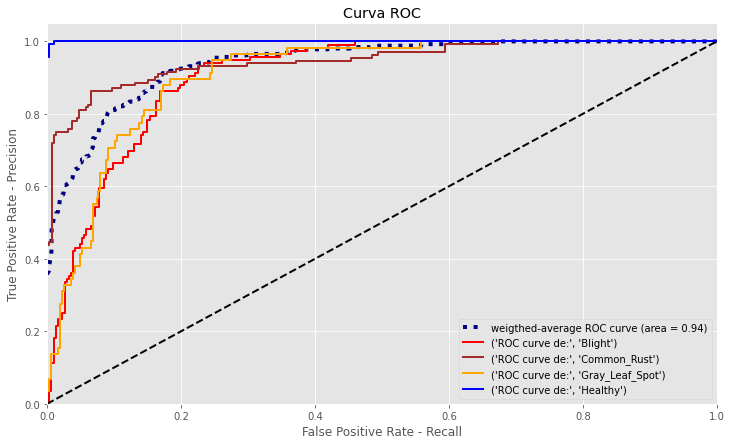

In [8]:
plot_roc_curve(y_test, reconstructed_model.predict(X_test))

In [13]:
# De un vistazo, matriz de confusión
cm = confusion_matrix(y_test, np.argmax(reconstructed_model.predict(X_test), axis=1))
cm_dec = [ cm[i] / np.sum(cm[i]) for i in range(len(cm))]
cm_per = [ [ str(round(x*100,1))+"%" for x in my_list] for my_list in cm_dec ]
cm_per

[['81.0%', '8.6%', '8.6%', '1.7%'],
 ['3.8%', '93.9%', '1.5%', '0.8%'],
 ['46.6%', '8.6%', '44.8%', '0.0%'],
 ['0.0%', '0.0%', '0.0%', '100.0%']]

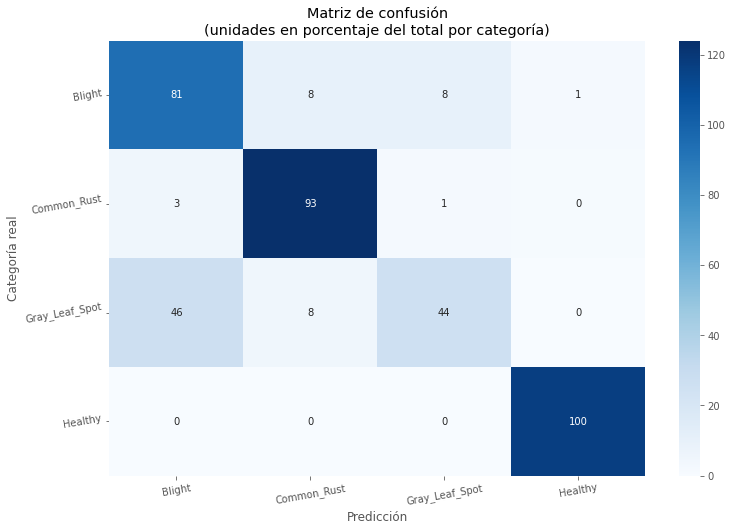

In [10]:
plot_cm(y_test, np.argmax(reconstructed_model.predict(X_test),axis=1))